In [2]:
!git clone https://github.com/pytorch/vision.git  #Training Metric Utilities from Torchvision

Cloning into 'vision'...
remote: Enumerating objects: 636650, done.
remote: Counting objects: 100% (391/391), done.
remote: Compressing objects: 100% (259/259), done.
remote: Total 636650 (delta 240), reused 133 (delta 132), pack-reused 636259 (from 3)
Receiving objects: 100% (636650/636650), 1.18 GiB | 45.47 MiB/s, done.
Resolving deltas: 100% (595489/595489), done.


In [3]:
import os
import gc
import json
import math
import random
import requests
import zipfile
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageStat
import PIL
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import logging
from tqdm import tqdm
 
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from dataclasses import dataclass
import torchvision
from vision.references.detection import utils
 
import torchvision.transforms as T
from torchvision.transforms import v2 as Tv2
from torchvision import tv_tensors
from torchvision.transforms import functional as F
from torchvision.transforms.functional import to_pil_image
 
import torchvision.models.detection as detection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform

def set_seeds():
    # fix random seeds
    SEED_VALUE = 42
 
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
set_seeds()

2025-05-28 21:45:36.792713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748468736.997204      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748468737.055348      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import json
import logging
from PIL import Image, ImageStat

logging.basicConfig(level=logging.INFO)
from PIL import ImageStat

def is_bbox_ignored(image, bbox, threshold=10):
    x, y, w, h = bbox
    if w <= 0 or h <= 0:
        return True  # Invalid bounding box

    cropped_image = image.crop((x, y, x + w, y + h))

    if cropped_image.width == 0 or cropped_image.height == 0:
        return True  # Empty crop, ignore

    stat = ImageStat.Stat(cropped_image)
    
    try:
        avg_color = stat.mean  # Average color (R, G, B)
    except ZeroDivisionError:
        return True  # Fallback in case it's still empty somehow

    # Check if all color channels are below the threshold
    return all(channel < threshold for channel in avg_color)


def check_and_rotate_image(image):
    width, height = image.size
    if height > width:
        return image.rotate(90, expand=True), True
    return image, False

def adjust_bbox_for_rotation(bbox, image_width, image_height):
    x, y, w, h = bbox
    new_x = y
    new_y = image_width - (x + w)
    return [new_x, new_y, h, w]

def rotate_image_and_adjust_bbox(image, annotations, original_dims, image_id):
    rotated_image = image.rotate(90, expand=True)
    new_annotations = []
    original_width, _ = original_dims
    for ann in annotations:
        if ann['image_id'] != image_id:
            continue
        x, y, w, h = ann['bbox']
        new_x = y
        new_y = original_width - (x + w)
        new_bbox = [new_x, new_y, h, w]
        new_ann = ann.copy()
        new_ann['bbox'] = new_bbox
        new_annotations.append(new_ann)
    return rotated_image, new_annotations

def create_patches(image, output_dir, image_filename, overlap_ratio=0.2):
    image, was_rotated = check_and_rotate_image(image)
    width, height = image.size
    patch_width = int(width / 2)
    patch_height = int(height / 2)
    overlap_w = int(patch_width * overlap_ratio)
    overlap_h = int(patch_height * overlap_ratio)
    patches = []

    for i in range(2):
        for j in range(2):
            left = i * (patch_width - overlap_w)
            top = j * (patch_height - overlap_h)
            right = min(left + patch_width, width)
            bottom = min(top + patch_height, height)
            patch = image.crop((left, top, right, bottom))
            patch_filename = f'{os.path.splitext(image_filename)[0]}_{i}_{j}.jpg'
            patch_path = os.path.join(output_dir, patch_filename)
            patch.save(patch_path)
            patches.append((patch_filename, left, top, right, bottom, was_rotated, patch))
    return patches

def adjust_bbox_for_patch(bbox, patch_coords):
    left, top, right, bottom = patch_coords
    x, y, w, h = bbox
    x1, y1 = x, y
    x2, y2 = x + w, y + h
    if x2 <= left or x1 >= right or y2 <= top or y1 >= bottom:
        return None
    clamped_x1 = max(x1, left)
    clamped_y1 = max(y1, top)
    clamped_x2 = min(x2, right)
    clamped_y2 = min(y2, bottom)
    new_w = clamped_x2 - clamped_x1
    new_h = clamped_y2 - clamped_y1
    if new_w <= 0 or new_h <= 0:
        return None
    return [clamped_x1 - left, clamped_y1 - top, new_w, new_h]

def get_annotations_for_patches(image, annotations, patches, original_image_id, starting_ann_id):
    patch_annotations = []
    new_images = []
    ann_id = starting_ann_id

    for idx, (patch_filename, left, top, right, bottom, was_rotated, patch_img) in enumerate(patches):
        patch_coords = (left, top, right, bottom)
        for ann in annotations:
            if ann['image_id'] != original_image_id:
                continue
            bbox = ann['bbox']
            if was_rotated:
                bbox = adjust_bbox_for_rotation(bbox, right - left, bottom - top)
            if is_bbox_ignored(image, bbox):
                continue
            adjusted_bbox = adjust_bbox_for_patch(bbox, patch_coords)
            if adjusted_bbox:
                patch_annotations.append({
                    "id": ann_id,
                    "image_id": patch_filename,
                    "bbox": adjusted_bbox,
                    "area": adjusted_bbox[2] * adjusted_bbox[3],
                    "category_id": ann['category_id'],
                    "iscrowd": 0
                })
                ann_id += 1
        new_images.append({
            "id": patch_filename,
            "file_name": patch_filename,
            "width": patch_img.size[0],
            "height": patch_img.size[1]
        })
    return patch_annotations, new_images, ann_id

def process_images_and_annotations(base_dir):
    splits = ['train', 'valid']
    for split in splits:
        ann_path = os.path.join(base_dir, split, '_annotations.coco.json')
        with open(ann_path, 'r') as f:
            coco_data = json.load(f)

        all_new_anns = []
        all_new_imgs = []
        ann_id = 1
        out_img_dir = os.path.join(base_dir, 'output_patches', 'images', split)
        out_ann_dir = os.path.join(base_dir, 'output_patches', 'annotations')
        os.makedirs(out_img_dir, exist_ok=True)
        os.makedirs(out_ann_dir, exist_ok=True)

        for img_info in coco_data['images']:
            img_id = img_info['id']
            filename = img_info['file_name']
            img_path = os.path.join(base_dir, split, filename)
            if not os.path.exists(img_path):
                continue
            img = Image.open(img_path)
            img = img.convert("RGB")
            orig_dims = (img_info['width'], img_info['height'])

            if img_info['height'] > img_info['width']:
                rotated_img, anns = rotate_image_and_adjust_bbox(img, coco_data['annotations'], orig_dims, img_id)
            else:
                rotated_img = img
                anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]

            patches = create_patches(rotated_img, out_img_dir, filename)
            patch_anns, patch_imgs, ann_id = get_annotations_for_patches(rotated_img, anns, patches, img_id, ann_id)
            all_new_anns.extend(patch_anns)
            all_new_imgs.extend(patch_imgs)

        out_coco = {
            "images": all_new_imgs,
            "annotations": all_new_anns,
            "categories": coco_data['categories']
        }

        with open(os.path.join(out_ann_dir, f'instances_{split}.json'), 'w') as f:
            json.dump(out_coco, f, indent=4)

# Set your base directory (containing 'train' and 'valid' folders)
base_dir = '/kaggle/working/warehouse-1'
process_images_and_annotations(base_dir)


In [5]:
from dataclasses import dataclass
@dataclass
class DatasetConfig:
    root: str
    annotations_file: str
    train_img_size: tuple
    subset: str = 'train'  # Default to 'train'
    transforms: any = None

class CustomAerialDataset(Dataset):
    def __init__(self, config: DatasetConfig):
        self.root = config.root
        self.transforms = config.transforms
        self.train_img_size = config.train_img_size
        self.subset = config.subset
        self.annotations_file = os.path.join(self.root, 'annotations', f'instances_{self.subset}.json')
        self.imgs = []
        self.img_annotations = {}
        self._load_images()
        self._load_annotations()
 
    def __len__(self):
        return len(self.imgs)
    def _load_images(self):
        # Load all images from the subset directory
        images_path = os.path.join(self.root, 'images', self.subset)
        for image_filename in os.listdir(images_path):
            image_path = os.path.join(images_path, image_filename)
            if os.path.isfile(image_path) and image_path.endswith(('.png', '.jpg', '.jpeg')):
                self.imgs.append(image_path)
                image_id = os.path.basename(image_path)
                # Initialize empty annotations for each image
                if image_id not in self.img_annotations:
                    self.img_annotations[image_id] = {'boxes': [], 'labels': []}
    def _load_annotations(self):
         with open(self.annotations_file, 'r') as f:
            data = json.load(f)
            for annotation in data['annotations']:
                image_id = annotation["image_id"]
                bbox = annotation["bbox"]
                category_id = annotation["category_id"]
                image_path = os.path.join(self.root, 'images', self.subset, image_id)
                if image_id in self.img_annotations:
                    self.img_annotations[image_id]['boxes'].append(bbox)
                    self.img_annotations[image_id]['labels'].append(category_id)
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        if not os.path.exists(img_path):
            # Return a default image (like a zero tensor) and a dummy target
            default_img = torch.zeros(3, *self.train_img_size)  # Assuming 3 color channels
            default_target = {'boxes': torch.tensor([[0, 0, 0, 0]], dtype=torch.float32),
                              'labels': torch.tensor([0], dtype=torch.int64)}  # Background
            return default_img, default_target
 
        img = Image.open(img_path).convert("RGB")
        orig_width, orig_height = img.size
        scale_x = self.train_img_size[0] / orig_width
        scale_y = self.train_img_size[1] / orig_height
        img = img.resize(self.train_img_size, Image.BILINEAR)
        img = F.to_tensor(img)
 
        annotations = self.img_annotations[os.path.basename(img_path)]
        if annotations['boxes']:
            scaled_boxes = [[max(0, min(bbox[0] * scale_x, self.train_img_size[0])),
                             max(0, min(bbox[1] * scale_y, self.train_img_size[1])),
                             max(0, min((bbox[0] + bbox[2]) * scale_x, self.train_img_size[0])),
                             max(0, min((bbox[1] + bbox[3]) * scale_y, self.train_img_size[1]))]
                            for bbox in annotations['boxes']]
            labels = annotations['labels']
        else:
            scaled_boxes = [[0, 0, 0, 0]]
            labels = [0]
 
        boxes = torch.tensor(scaled_boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
 
        target = {'boxes': boxes, 'labels': labels}
        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

def get_transform(train):
    transforms = []
    # if train:
        # transforms.append(Tv2.RandomHorizontalFlip(0.5))
    transforms.append(Tv2.ToDtype(torch.float, scale=True))
    transforms.append(Tv2.ToPureTensor())
    return Tv2.Compose(transforms)

In [6]:
root = "/kaggle/working/warehouse-1/output_patches"
 
# Configuration for training and validation datasets
train_config = DatasetConfig(root,
                             annotations_file='',  # This is now set based on subset in the __init__
                             train_img_size=(416, 416),
                             subset='train',
                             transforms=get_transform(train=True))
val_config = DatasetConfig(root,
                           annotations_file='',
                           train_img_size=(416, 416),
                           subset='valid',
                           transforms=get_transform(train=False))
 
train_dataset = CustomAerialDataset(train_config)
val_dataset = CustomAerialDataset(val_config)
 
print(f"Length of Train Dataset: {len(train_dataset)}")
print(f"Length of Validation Dataset: {len(val_dataset)}")

Length of Train Dataset: 42924
Length of Validation Dataset: 5076


In [7]:
from torch.utils.data import Subset
def collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    real_targets = []
    for target in targets:
        # Filter out dummy boxes
        mask = target['boxes'].sum(dim=1) > 0
        real_targets.append({'boxes': target['boxes'][mask], 'labels': target['labels'][mask]})
    return imgs, real_targets

limited_train_dataset = Subset(train_dataset, range(5000))
limited_valid_dataset = Subset(val_dataset, range(200))

train_data_loader = DataLoader(limited_train_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn, num_workers=12)
val_data_loader = DataLoader(limited_valid_dataset, batch_size=10, shuffle=False, collate_fn=collate_fn, num_workers=12)

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [8]:
def show_image_with_boxes(img, targets, ax, category_colors):
    """Plot an image with its bounding boxes on an axis object."""
    # Convert tensor image to PIL for display if needed
    if isinstance(img, torch.Tensor):
        img = to_pil_image(img)
        print(img.size)
    ax.imshow(img)
 
    # Check and plot each bounding box with class-specific color
    if 'boxes' in targets and 'labels' in targets:
        boxes = targets['boxes'].cpu().numpy()
        labels = targets['labels'].cpu().numpy()
        for bbox, label in zip(boxes, labels):
            w = bbox[2]-bbox[0]
            h = bbox[3]-bbox[1]
            color = category_colors.get(label, 'gray')  # Use gray for unmapped classes
            rect = patches.Rectangle((bbox[0], bbox[1]), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1], str(label), color='white', fontsize=12, bbox=dict(facecolor=color, alpha=0.5))
 
def visualize_samples(data_loader, category_colors, num_samples=20):
    """Visualize a specified number of samples from a DataLoader in a single column."""
    num_rows = num_samples  # All samples in a single column
    num_cols = 1
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 25 * num_rows // 4))  # Adjust height based on rows
    samples_visualized = 0
 
    for images, targets in data_loader:
        for i, ax in enumerate(axs.flat):
            if samples_visualized >= num_samples:
                break  # Stop after displaying the desired number of samples
 
            show_image_with_boxes(images[i], targets[i], ax, category_colors)
            ax.axis('off')  # Turn off axis for cleaner look
            samples_visualized += 1
 
        # If enough samples visualized, break the loop to avoid extra iterations
        if samples_visualized >= num_samples:
            break
 
    plt.tight_layout()
    plt.show()


In [9]:
num_epochs = 25
best_map = -float('inf') # Training loop
# print(best_map)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
def get_model(num_classes):
    model = detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
 
    #Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #Replace pretrained head with new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model
 
num_classes = 6
model = get_model(num_classes)
model.to(DEVICE)
 
print(model)
# print(model.fc1(x).size())
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params,lr=0.0005,momentum=0.9,weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=num_epochs//2,
    gamma=0.1
)
scaler = torch.cuda.amp.GradScaler()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 157MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


In [11]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/aerial_detection')
 
def train_one_epoch(model, data_loader, device, optimizer, print_freq, epoch, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Training Epoch {epoch}:"
    model.to(device)
 
    with tqdm(data_loader, desc=header) as tq:
        lr_scheduler = None
        for i, (images, targets) in enumerate(tq):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
 
            with torch.cuda.amp.autocast(enabled=scaler is not None):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
 
            loss_value = losses.item()
            optimizer.zero_grad()
 
            if scaler is not None:
                scaler.scale(losses).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                losses.backward()
                optimizer.step()
 
            if lr_scheduler is not None:
                lr_scheduler.step()
 
            metric_logger.update(loss=losses, **loss_dict)
            metric_logger.update(lr=optimizer.param_groups[0]["lr"])
 
            # Update tqdm postfix to display loss on the progress bar
            tq.set_postfix(loss=losses.item(), lr=optimizer.param_groups[0]["lr"])
 
            # Log losses to TensorBoard
            writer.add_scalar('Loss/train', losses.item(), epoch * len(data_loader) + i)
            for k, v in loss_dict.items():
                writer.add_scalar(f'Loss/train_{k}', v.item(), epoch * len(data_loader) + i)
 
    print(f"Average Loss: {metric_logger.meters['loss'].global_avg:.4f}")
    writer.add_scalar('Loss/avg_train', metric_logger.meters['loss'].global_avg, epoch)



def evaluate(model, data_loader, device, epoch, save_dir):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    total_iou = 0
    total_detections = 0
    header = "Validation:"
    total_steps = len(data_loader)
    samples = []
 
    with torch.no_grad(), tqdm(total=total_steps, desc=header) as progress_bar:
        for i, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
 
            # Convert outputs for torchmetrics
            preds = [
                {"boxes": out["boxes"], "scores": out["scores"], "labels": out["labels"]}
                for out in outputs
            ]
            targs = [
                {"boxes": tgt["boxes"], "labels": tgt["labels"]}
                for tgt in targets
            ]
 
            # Update metric for mAP calculation
            metric.update(preds, targs)
 
            # Collect samples for visualization (limit to 5)
            if len(samples) < 5:
                for img, out, tgt in zip(images, outputs, targets):
                    samples.append((img, out, tgt))
                    if len(samples) >= 5:
                        break
 
            progress_bar.update(1)
 
    # Visualize predictions
    results = metric.compute()
    print("mAP results:")
    print(results)
 
    # Log mAP to TensorBoard
 
    for k, v in results.items():
        if v.numel() == 1:  # Single element tensor
            writer.add_scalar(f'mAP/{k}', v.item(), epoch)
        else:  # Multi-element tensor, log each element separately
            for idx, value in enumerate(v):
                writer.add_scalar(f'mAP/{k}_{idx}', value.item(), epoch)
    return results

In [12]:
print(len(train_data_loader))

500


Training Epoch 0:: 100%|██████████| 500/500 [02:44<00:00,  3.05it/s, loss=0.79, lr=0.0005]


Average Loss: 1.0728


Validation:: 100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


mAP results:
{'map': tensor(0.0621), 'map_50': tensor(0.1279), 'map_75': tensor(0.0534), 'map_small': tensor(0.0109), 'map_medium': tensor(0.0710), 'map_large': tensor(0.1306), 'mar_1': tensor(0.0725), 'mar_10': tensor(0.1664), 'mar_100': tensor(0.1952), 'mar_small': tensor(0.0350), 'mar_medium': tensor(0.1908), 'mar_large': tensor(0.3805), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


mAP results:
{'map': tensor(0.0032), 'map_50': tensor(0.0054), 'map_75': tensor(0.0040), 'map_small': tensor(1.8602e-05), 'map_medium': tensor(0.0005), 'map_large': tensor(0.0076), 'mar_1': tensor(0.0061), 'mar_10': tensor(0.0078), 'mar_100': tensor(0.0087), 'mar_small': tensor(0.0011), 'mar_medium': tensor(0.0066), 'mar_large': tensor(0.0140), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 1:: 100%|██████████| 500/500 [02:42<00:00,  3.08it/s, loss=0.851, lr=0.0005]


Average Loss: 0.8774


Validation:: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


mAP results:
{'map': tensor(0.1030), 'map_50': tensor(0.1986), 'map_75': tensor(0.0938), 'map_small': tensor(0.0167), 'map_medium': tensor(0.1077), 'map_large': tensor(0.2187), 'mar_1': tensor(0.1063), 'mar_10': tensor(0.2282), 'mar_100': tensor(0.2667), 'mar_small': tensor(0.0517), 'mar_medium': tensor(0.2658), 'mar_large': tensor(0.4723), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


mAP results:
{'map': tensor(0.0030), 'map_50': tensor(0.0075), 'map_75': tensor(0.0024), 'map_small': tensor(1.9983e-05), 'map_medium': tensor(0.0023), 'map_large': tensor(0.0058), 'mar_1': tensor(0.0110), 'mar_10': tensor(0.0187), 'mar_100': tensor(0.0200), 'mar_small': tensor(0.0012), 'mar_medium': tensor(0.0139), 'mar_large': tensor(0.0302), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 2:: 100%|██████████| 500/500 [02:40<00:00,  3.11it/s, loss=0.833, lr=0.0005]


Average Loss: 0.8095


Validation:: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


mAP results:
{'map': tensor(0.1286), 'map_50': tensor(0.2435), 'map_75': tensor(0.1203), 'map_small': tensor(0.0203), 'map_medium': tensor(0.1303), 'map_large': tensor(0.2622), 'mar_1': tensor(0.1311), 'mar_10': tensor(0.2631), 'mar_100': tensor(0.3045), 'mar_small': tensor(0.0595), 'mar_medium': tensor(0.2968), 'mar_large': tensor(0.5261), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


mAP results:
{'map': tensor(0.0035), 'map_50': tensor(0.0108), 'map_75': tensor(0.0026), 'map_small': tensor(3.4744e-05), 'map_medium': tensor(0.0035), 'map_large': tensor(0.0080), 'mar_1': tensor(0.0111), 'mar_10': tensor(0.0197), 'mar_100': tensor(0.0216), 'mar_small': tensor(0.0017), 'mar_medium': tensor(0.0154), 'mar_large': tensor(0.0337), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 3:: 100%|██████████| 500/500 [02:39<00:00,  3.13it/s, loss=0.776, lr=0.0005]


Average Loss: 0.7734


Validation:: 100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


mAP results:
{'map': tensor(0.1575), 'map_50': tensor(0.2844), 'map_75': tensor(0.1528), 'map_small': tensor(0.0239), 'map_medium': tensor(0.1570), 'map_large': tensor(0.3177), 'mar_1': tensor(0.1578), 'mar_10': tensor(0.2991), 'mar_100': tensor(0.3420), 'mar_small': tensor(0.0653), 'mar_medium': tensor(0.3326), 'mar_large': tensor(0.5797), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


mAP results:
{'map': tensor(0.0040), 'map_50': tensor(0.0117), 'map_75': tensor(0.0034), 'map_small': tensor(4.0226e-05), 'map_medium': tensor(0.0040), 'map_large': tensor(0.0082), 'mar_1': tensor(0.0088), 'mar_10': tensor(0.0171), 'mar_100': tensor(0.0181), 'mar_small': tensor(0.0011), 'mar_medium': tensor(0.0135), 'mar_large': tensor(0.0287), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 4:: 100%|██████████| 500/500 [02:39<00:00,  3.14it/s, loss=0.655, lr=0.0005]


Average Loss: 0.7469


Validation:: 100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


mAP results:
{'map': tensor(0.1785), 'map_50': tensor(0.3156), 'map_75': tensor(0.1762), 'map_small': tensor(0.0272), 'map_medium': tensor(0.1749), 'map_large': tensor(0.3474), 'mar_1': tensor(0.1785), 'mar_10': tensor(0.3395), 'mar_100': tensor(0.3866), 'mar_small': tensor(0.0754), 'mar_medium': tensor(0.3809), 'mar_large': tensor(0.6289), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


mAP results:
{'map': tensor(0.0039), 'map_50': tensor(0.0134), 'map_75': tensor(0.0023), 'map_small': tensor(3.8061e-05), 'map_medium': tensor(0.0039), 'map_large': tensor(0.0112), 'mar_1': tensor(0.0123), 'mar_10': tensor(0.0253), 'mar_100': tensor(0.0264), 'mar_small': tensor(0.0011), 'mar_medium': tensor(0.0193), 'mar_large': tensor(0.0470), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 5:: 100%|██████████| 500/500 [02:38<00:00,  3.15it/s, loss=0.787, lr=0.0005]


Average Loss: 0.7256


Validation:: 100%|██████████| 500/500 [02:05<00:00,  3.98it/s]


mAP results:
{'map': tensor(0.1963), 'map_50': tensor(0.3395), 'map_75': tensor(0.1954), 'map_small': tensor(0.0300), 'map_medium': tensor(0.1885), 'map_large': tensor(0.3825), 'mar_1': tensor(0.1872), 'mar_10': tensor(0.3480), 'mar_100': tensor(0.3933), 'mar_small': tensor(0.0825), 'mar_medium': tensor(0.3846), 'mar_large': tensor(0.6377), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


mAP results:
{'map': tensor(0.0034), 'map_50': tensor(0.0119), 'map_75': tensor(0.0005), 'map_small': tensor(7.5399e-05), 'map_medium': tensor(0.0046), 'map_large': tensor(0.0090), 'mar_1': tensor(0.0109), 'mar_10': tensor(0.0228), 'mar_100': tensor(0.0242), 'mar_small': tensor(0.0014), 'mar_medium': tensor(0.0197), 'mar_large': tensor(0.0401), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 6:: 100%|██████████| 500/500 [02:38<00:00,  3.16it/s, loss=0.754, lr=0.0005]


Average Loss: 0.7094


Validation:: 100%|██████████| 500/500 [02:00<00:00,  4.16it/s]


mAP results:
{'map': tensor(0.2131), 'map_50': tensor(0.3619), 'map_75': tensor(0.2130), 'map_small': tensor(0.0315), 'map_medium': tensor(0.2045), 'map_large': tensor(0.4084), 'mar_1': tensor(0.2000), 'mar_10': tensor(0.3637), 'mar_100': tensor(0.4084), 'mar_small': tensor(0.0826), 'mar_medium': tensor(0.4032), 'mar_large': tensor(0.6539), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


mAP results:
{'map': tensor(0.0050), 'map_50': tensor(0.0159), 'map_75': tensor(0.0010), 'map_small': tensor(5.2006e-05), 'map_medium': tensor(0.0066), 'map_large': tensor(0.0074), 'mar_1': tensor(0.0122), 'mar_10': tensor(0.0195), 'mar_100': tensor(0.0203), 'mar_small': tensor(0.0012), 'mar_medium': tensor(0.0188), 'mar_large': tensor(0.0301), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 7:: 100%|██████████| 500/500 [02:37<00:00,  3.17it/s, loss=0.713, lr=0.0005]


Average Loss: 0.6968


Validation:: 100%|██████████| 500/500 [01:59<00:00,  4.18it/s]


mAP results:
{'map': tensor(0.2223), 'map_50': tensor(0.3738), 'map_75': tensor(0.2247), 'map_small': tensor(0.0340), 'map_medium': tensor(0.2156), 'map_large': tensor(0.4230), 'mar_1': tensor(0.2026), 'mar_10': tensor(0.3652), 'mar_100': tensor(0.4088), 'mar_small': tensor(0.0854), 'mar_medium': tensor(0.4048), 'mar_large': tensor(0.6529), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


mAP results:
{'map': tensor(0.0045), 'map_50': tensor(0.0148), 'map_75': tensor(0.0004), 'map_small': tensor(2.5092e-05), 'map_medium': tensor(0.0067), 'map_large': tensor(0.0069), 'mar_1': tensor(0.0134), 'mar_10': tensor(0.0202), 'mar_100': tensor(0.0209), 'mar_small': tensor(0.0011), 'mar_medium': tensor(0.0187), 'mar_large': tensor(0.0296), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 8:: 100%|██████████| 500/500 [02:37<00:00,  3.18it/s, loss=0.563, lr=0.0005]


Average Loss: 0.6848


Validation:: 100%|██████████| 500/500 [02:00<00:00,  4.15it/s]


mAP results:
{'map': tensor(0.2349), 'map_50': tensor(0.3900), 'map_75': tensor(0.2369), 'map_small': tensor(0.0355), 'map_medium': tensor(0.2287), 'map_large': tensor(0.4437), 'mar_1': tensor(0.2091), 'mar_10': tensor(0.3730), 'mar_100': tensor(0.4175), 'mar_small': tensor(0.0896), 'mar_medium': tensor(0.4161), 'mar_large': tensor(0.6622), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


mAP results:
{'map': tensor(0.0058), 'map_50': tensor(0.0175), 'map_75': tensor(0.0010), 'map_small': tensor(4.3131e-05), 'map_medium': tensor(0.0068), 'map_large': tensor(0.0084), 'mar_1': tensor(0.0131), 'mar_10': tensor(0.0191), 'mar_100': tensor(0.0200), 'mar_small': tensor(0.0014), 'mar_medium': tensor(0.0163), 'mar_large': tensor(0.0333), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 9:: 100%|██████████| 500/500 [02:36<00:00,  3.19it/s, loss=0.849, lr=0.0005]


Average Loss: 0.6750


Validation:: 100%|██████████| 500/500 [01:55<00:00,  4.32it/s]


mAP results:
{'map': tensor(0.2429), 'map_50': tensor(0.3993), 'map_75': tensor(0.2465), 'map_small': tensor(0.0363), 'map_medium': tensor(0.2378), 'map_large': tensor(0.4580), 'mar_1': tensor(0.2176), 'mar_10': tensor(0.3877), 'mar_100': tensor(0.4317), 'mar_small': tensor(0.0941), 'mar_medium': tensor(0.4391), 'mar_large': tensor(0.6735), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


mAP results:
{'map': tensor(0.0054), 'map_50': tensor(0.0157), 'map_75': tensor(0.0003), 'map_small': tensor(2.1702e-05), 'map_medium': tensor(0.0051), 'map_large': tensor(0.0103), 'mar_1': tensor(0.0102), 'mar_10': tensor(0.0153), 'mar_100': tensor(0.0154), 'mar_small': tensor(0.0004), 'mar_medium': tensor(0.0125), 'mar_large': tensor(0.0243), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 10:: 100%|██████████| 500/500 [02:36<00:00,  3.19it/s, loss=0.577, lr=0.0005]


Average Loss: 0.6639


Validation:: 100%|██████████| 500/500 [02:00<00:00,  4.13it/s]


mAP results:
{'map': tensor(0.2570), 'map_50': tensor(0.4195), 'map_75': tensor(0.2626), 'map_small': tensor(0.0399), 'map_medium': tensor(0.2504), 'map_large': tensor(0.4785), 'mar_1': tensor(0.2206), 'mar_10': tensor(0.3959), 'mar_100': tensor(0.4418), 'mar_small': tensor(0.0981), 'mar_medium': tensor(0.4461), 'mar_large': tensor(0.6913), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


mAP results:
{'map': tensor(0.0080), 'map_50': tensor(0.0218), 'map_75': tensor(0.0057), 'map_small': tensor(5.1945e-05), 'map_medium': tensor(0.0065), 'map_large': tensor(0.0150), 'mar_1': tensor(0.0155), 'mar_10': tensor(0.0223), 'mar_100': tensor(0.0234), 'mar_small': tensor(0.0011), 'mar_medium': tensor(0.0187), 'mar_large': tensor(0.0385), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 11:: 100%|██████████| 500/500 [02:36<00:00,  3.20it/s, loss=0.586, lr=0.0005]


Average Loss: 0.6559


Validation:: 100%|██████████| 500/500 [02:02<00:00,  4.09it/s]


mAP results:
{'map': tensor(0.2651), 'map_50': tensor(0.4297), 'map_75': tensor(0.2701), 'map_small': tensor(0.0417), 'map_medium': tensor(0.2573), 'map_large': tensor(0.4885), 'mar_1': tensor(0.2244), 'mar_10': tensor(0.4068), 'mar_100': tensor(0.4550), 'mar_small': tensor(0.1066), 'mar_medium': tensor(0.4629), 'mar_large': tensor(0.7017), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


mAP results:
{'map': tensor(0.0075), 'map_50': tensor(0.0206), 'map_75': tensor(0.0025), 'map_small': tensor(2.7183e-05), 'map_medium': tensor(0.0076), 'map_large': tensor(0.0167), 'mar_1': tensor(0.0179), 'mar_10': tensor(0.0352), 'mar_100': tensor(0.0364), 'mar_small': tensor(0.0014), 'mar_medium': tensor(0.0242), 'mar_large': tensor(0.0748), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 12:: 100%|██████████| 500/500 [02:35<00:00,  3.21it/s, loss=0.969, lr=0.0005]


Average Loss: 0.6499


Validation:: 100%|██████████| 500/500 [01:57<00:00,  4.25it/s]


mAP results:
{'map': tensor(0.2778), 'map_50': tensor(0.4416), 'map_75': tensor(0.2858), 'map_small': tensor(0.0425), 'map_medium': tensor(0.2682), 'map_large': tensor(0.5107), 'mar_1': tensor(0.2294), 'mar_10': tensor(0.4100), 'mar_100': tensor(0.4556), 'mar_small': tensor(0.1031), 'mar_medium': tensor(0.4592), 'mar_large': tensor(0.7103), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


mAP results:
{'map': tensor(0.0075), 'map_50': tensor(0.0180), 'map_75': tensor(0.0045), 'map_small': tensor(3.2537e-05), 'map_medium': tensor(0.0068), 'map_large': tensor(0.0133), 'mar_1': tensor(0.0128), 'mar_10': tensor(0.0202), 'mar_100': tensor(0.0207), 'mar_small': tensor(0.0010), 'mar_medium': tensor(0.0175), 'mar_large': tensor(0.0339), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 13:: 100%|██████████| 500/500 [02:35<00:00,  3.21it/s, loss=0.538, lr=0.0005]


Average Loss: 0.6420


Validation:: 100%|██████████| 500/500 [01:58<00:00,  4.22it/s]


mAP results:
{'map': tensor(0.2855), 'map_50': tensor(0.4508), 'map_75': tensor(0.2951), 'map_small': tensor(0.0448), 'map_medium': tensor(0.2793), 'map_large': tensor(0.5213), 'mar_1': tensor(0.2324), 'mar_10': tensor(0.4204), 'mar_100': tensor(0.4663), 'mar_small': tensor(0.1074), 'mar_medium': tensor(0.4760), 'mar_large': tensor(0.7186), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


mAP results:
{'map': tensor(0.0084), 'map_50': tensor(0.0205), 'map_75': tensor(0.0048), 'map_small': tensor(3.3710e-05), 'map_medium': tensor(0.0076), 'map_large': tensor(0.0195), 'mar_1': tensor(0.0131), 'mar_10': tensor(0.0291), 'mar_100': tensor(0.0306), 'mar_small': tensor(0.0007), 'mar_medium': tensor(0.0238), 'mar_large': tensor(0.0620), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 14:: 100%|██████████| 500/500 [02:35<00:00,  3.22it/s, loss=0.468, lr=0.0005]


Average Loss: 0.6329


Validation:: 100%|██████████| 500/500 [01:58<00:00,  4.23it/s]


mAP results:
{'map': tensor(0.2898), 'map_50': tensor(0.4607), 'map_75': tensor(0.3012), 'map_small': tensor(0.0465), 'map_medium': tensor(0.2850), 'map_large': tensor(0.5255), 'mar_1': tensor(0.2365), 'mar_10': tensor(0.4214), 'mar_100': tensor(0.4674), 'mar_small': tensor(0.1100), 'mar_medium': tensor(0.4764), 'mar_large': tensor(0.7189), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


mAP results:
{'map': tensor(0.0086), 'map_50': tensor(0.0216), 'map_75': tensor(0.0068), 'map_small': tensor(5.1455e-05), 'map_medium': tensor(0.0066), 'map_large': tensor(0.0177), 'mar_1': tensor(0.0158), 'mar_10': tensor(0.0252), 'mar_100': tensor(0.0256), 'mar_small': tensor(0.0013), 'mar_medium': tensor(0.0183), 'mar_large': tensor(0.0488), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 15:: 100%|██████████| 500/500 [02:34<00:00,  3.23it/s, loss=0.715, lr=0.0005]


Average Loss: 0.6292


Validation:: 100%|██████████| 500/500 [01:53<00:00,  4.40it/s]


mAP results:
{'map': tensor(0.3020), 'map_50': tensor(0.4737), 'map_75': tensor(0.3133), 'map_small': tensor(0.0469), 'map_medium': tensor(0.2960), 'map_large': tensor(0.5433), 'mar_1': tensor(0.2430), 'mar_10': tensor(0.4320), 'mar_100': tensor(0.4762), 'mar_small': tensor(0.1143), 'mar_medium': tensor(0.4887), 'mar_large': tensor(0.7259), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


mAP results:
{'map': tensor(0.0065), 'map_50': tensor(0.0139), 'map_75': tensor(0.0062), 'map_small': tensor(2.1414e-05), 'map_medium': tensor(0.0066), 'map_large': tensor(0.0128), 'mar_1': tensor(0.0063), 'mar_10': tensor(0.0163), 'mar_100': tensor(0.0163), 'mar_small': tensor(0.0004), 'mar_medium': tensor(0.0129), 'mar_large': tensor(0.0316), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 16:: 100%|██████████| 500/500 [02:34<00:00,  3.24it/s, loss=0.485, lr=0.0005]


Average Loss: 0.6242


Validation:: 100%|██████████| 500/500 [01:55<00:00,  4.31it/s]


mAP results:
{'map': tensor(0.3089), 'map_50': tensor(0.4827), 'map_75': tensor(0.3247), 'map_small': tensor(0.0485), 'map_medium': tensor(0.3059), 'map_large': tensor(0.5505), 'mar_1': tensor(0.2438), 'mar_10': tensor(0.4315), 'mar_100': tensor(0.4771), 'mar_small': tensor(0.1212), 'mar_medium': tensor(0.4879), 'mar_large': tensor(0.7287), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


mAP results:
{'map': tensor(0.0041), 'map_50': tensor(0.0137), 'map_75': tensor(0.0007), 'map_small': tensor(1.6330e-05), 'map_medium': tensor(0.0063), 'map_large': tensor(0.0081), 'mar_1': tensor(0.0065), 'mar_10': tensor(0.0136), 'mar_100': tensor(0.0142), 'mar_small': tensor(0.0005), 'mar_medium': tensor(0.0145), 'mar_large': tensor(0.0218), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 17:: 100%|██████████| 500/500 [02:34<00:00,  3.24it/s, loss=0.489, lr=0.0005]


Average Loss: 0.6152


Validation:: 100%|██████████| 500/500 [01:55<00:00,  4.34it/s]


mAP results:
{'map': tensor(0.3143), 'map_50': tensor(0.4894), 'map_75': tensor(0.3294), 'map_small': tensor(0.0509), 'map_medium': tensor(0.3121), 'map_large': tensor(0.5581), 'mar_1': tensor(0.2436), 'mar_10': tensor(0.4394), 'mar_100': tensor(0.4852), 'mar_small': tensor(0.1255), 'mar_medium': tensor(0.4990), 'mar_large': tensor(0.7354), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


mAP results:
{'map': tensor(0.0067), 'map_50': tensor(0.0161), 'map_75': tensor(0.0038), 'map_small': tensor(4.5001e-05), 'map_medium': tensor(0.0079), 'map_large': tensor(0.0192), 'mar_1': tensor(0.0090), 'mar_10': tensor(0.0233), 'mar_100': tensor(0.0251), 'mar_small': tensor(0.0008), 'mar_medium': tensor(0.0214), 'mar_large': tensor(0.0417), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 18:: 100%|██████████| 500/500 [02:34<00:00,  3.24it/s, loss=0.522, lr=0.0005]


Average Loss: 0.6146


Validation:: 100%|██████████| 500/500 [01:54<00:00,  4.37it/s]


mAP results:
{'map': tensor(0.3175), 'map_50': tensor(0.4899), 'map_75': tensor(0.3303), 'map_small': tensor(0.0505), 'map_medium': tensor(0.3136), 'map_large': tensor(0.5657), 'mar_1': tensor(0.2457), 'mar_10': tensor(0.4336), 'mar_100': tensor(0.4778), 'mar_small': tensor(0.1153), 'mar_medium': tensor(0.4824), 'mar_large': tensor(0.7376), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


mAP results:
{'map': tensor(0.0052), 'map_50': tensor(0.0161), 'map_75': tensor(0.0029), 'map_small': tensor(5.7033e-05), 'map_medium': tensor(0.0067), 'map_large': tensor(0.0130), 'mar_1': tensor(0.0119), 'mar_10': tensor(0.0195), 'mar_100': tensor(0.0216), 'mar_small': tensor(0.0006), 'mar_medium': tensor(0.0199), 'mar_large': tensor(0.0340), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 19:: 100%|██████████| 500/500 [02:33<00:00,  3.25it/s, loss=0.588, lr=0.0005]


Average Loss: 0.6073


Validation:: 100%|██████████| 500/500 [01:54<00:00,  4.36it/s]


mAP results:
{'map': tensor(0.3324), 'map_50': tensor(0.5116), 'map_75': tensor(0.3498), 'map_small': tensor(0.0581), 'map_medium': tensor(0.3283), 'map_large': tensor(0.5854), 'mar_1': tensor(0.2553), 'mar_10': tensor(0.4521), 'mar_100': tensor(0.4974), 'mar_small': tensor(0.1310), 'mar_medium': tensor(0.5134), 'mar_large': tensor(0.7492), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


mAP results:
{'map': tensor(0.0060), 'map_50': tensor(0.0160), 'map_75': tensor(0.0052), 'map_small': tensor(4.9660e-05), 'map_medium': tensor(0.0067), 'map_large': tensor(0.0184), 'mar_1': tensor(0.0135), 'mar_10': tensor(0.0221), 'mar_100': tensor(0.0238), 'mar_small': tensor(0.0003), 'mar_medium': tensor(0.0189), 'mar_large': tensor(0.0372), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 20:: 100%|██████████| 500/500 [02:33<00:00,  3.25it/s, loss=0.645, lr=0.0005]


Average Loss: 0.6014


Validation:: 100%|██████████| 500/500 [01:55<00:00,  4.34it/s]


mAP results:
{'map': tensor(0.3371), 'map_50': tensor(0.5150), 'map_75': tensor(0.3572), 'map_small': tensor(0.0586), 'map_medium': tensor(0.3326), 'map_large': tensor(0.5925), 'mar_1': tensor(0.2570), 'mar_10': tensor(0.4522), 'mar_100': tensor(0.4985), 'mar_small': tensor(0.1328), 'mar_medium': tensor(0.5068), 'mar_large': tensor(0.7572), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


mAP results:
{'map': tensor(0.0063), 'map_50': tensor(0.0175), 'map_75': tensor(0.0034), 'map_small': tensor(2.1517e-05), 'map_medium': tensor(0.0070), 'map_large': tensor(0.0173), 'mar_1': tensor(0.0191), 'mar_10': tensor(0.0305), 'mar_100': tensor(0.0307), 'mar_small': tensor(0.0005), 'mar_medium': tensor(0.0186), 'mar_large': tensor(0.0589), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 21:: 100%|██████████| 500/500 [02:33<00:00,  3.26it/s, loss=0.545, lr=0.0005]


Average Loss: 0.5973


Validation:: 100%|██████████| 500/500 [01:54<00:00,  4.37it/s]


mAP results:
{'map': tensor(0.3395), 'map_50': tensor(0.5173), 'map_75': tensor(0.3560), 'map_small': tensor(0.0546), 'map_medium': tensor(0.3366), 'map_large': tensor(0.5928), 'mar_1': tensor(0.2548), 'mar_10': tensor(0.4526), 'mar_100': tensor(0.4984), 'mar_small': tensor(0.1331), 'mar_medium': tensor(0.5141), 'mar_large': tensor(0.7511), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


mAP results:
{'map': tensor(0.0049), 'map_50': tensor(0.0154), 'map_75': tensor(0.0033), 'map_small': tensor(4.9505e-05), 'map_medium': tensor(0.0071), 'map_large': tensor(0.0109), 'mar_1': tensor(0.0092), 'mar_10': tensor(0.0174), 'mar_100': tensor(0.0182), 'mar_small': tensor(0.0002), 'mar_medium': tensor(0.0182), 'mar_large': tensor(0.0305), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 22:: 100%|██████████| 500/500 [02:32<00:00,  3.27it/s, loss=0.655, lr=0.0005]


Average Loss: 0.5935


Validation:: 100%|██████████| 500/500 [01:54<00:00,  4.35it/s]


mAP results:
{'map': tensor(0.3506), 'map_50': tensor(0.5336), 'map_75': tensor(0.3697), 'map_small': tensor(0.0640), 'map_medium': tensor(0.3473), 'map_large': tensor(0.6091), 'mar_1': tensor(0.2608), 'mar_10': tensor(0.4606), 'mar_100': tensor(0.5070), 'mar_small': tensor(0.1396), 'mar_medium': tensor(0.5196), 'mar_large': tensor(0.7648), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


mAP results:
{'map': tensor(0.0048), 'map_50': tensor(0.0149), 'map_75': tensor(0.0034), 'map_small': tensor(4.2433e-05), 'map_medium': tensor(0.0069), 'map_large': tensor(0.0139), 'mar_1': tensor(0.0086), 'mar_10': tensor(0.0215), 'mar_100': tensor(0.0221), 'mar_small': tensor(0.0003), 'mar_medium': tensor(0.0232), 'mar_large': tensor(0.0323), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 23:: 100%|██████████| 500/500 [02:33<00:00,  3.26it/s, loss=0.704, lr=0.0005]


Average Loss: 0.5878


Validation:: 100%|██████████| 500/500 [01:53<00:00,  4.42it/s]


mAP results:
{'map': tensor(0.3564), 'map_50': tensor(0.5387), 'map_75': tensor(0.3747), 'map_small': tensor(0.0705), 'map_medium': tensor(0.3502), 'map_large': tensor(0.6184), 'mar_1': tensor(0.2605), 'mar_10': tensor(0.4582), 'mar_100': tensor(0.5038), 'mar_small': tensor(0.1394), 'mar_medium': tensor(0.5107), 'mar_large': tensor(0.7649), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


mAP results:
{'map': tensor(0.0049), 'map_50': tensor(0.0135), 'map_75': tensor(0.0021), 'map_small': tensor(5.1155e-05), 'map_medium': tensor(0.0077), 'map_large': tensor(0.0162), 'mar_1': tensor(0.0070), 'mar_10': tensor(0.0222), 'mar_100': tensor(0.0222), 'mar_small': tensor(0.0002), 'mar_medium': tensor(0.0180), 'mar_large': tensor(0.0417), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 24:: 100%|██████████| 500/500 [02:32<00:00,  3.27it/s, loss=0.639, lr=0.0005]


Average Loss: 0.5857


Validation:: 100%|██████████| 500/500 [01:53<00:00,  4.39it/s]


mAP results:
{'map': tensor(0.3623), 'map_50': tensor(0.5462), 'map_75': tensor(0.3814), 'map_small': tensor(0.0670), 'map_medium': tensor(0.3593), 'map_large': tensor(0.6247), 'mar_1': tensor(0.2666), 'mar_10': tensor(0.4725), 'mar_100': tensor(0.5181), 'mar_small': tensor(0.1379), 'mar_medium': tensor(0.5343), 'mar_large': tensor(0.7781), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Validation:: 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


mAP results:
{'map': tensor(0.0071), 'map_50': tensor(0.0181), 'map_75': tensor(0.0061), 'map_small': tensor(3.8504e-05), 'map_medium': tensor(0.0067), 'map_large': tensor(0.0226), 'mar_1': tensor(0.0131), 'mar_10': tensor(0.0282), 'mar_100': tensor(0.0283), 'mar_small': tensor(0.0002), 'mar_medium': tensor(0.0173), 'mar_large': tensor(0.0570), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}
That's it!


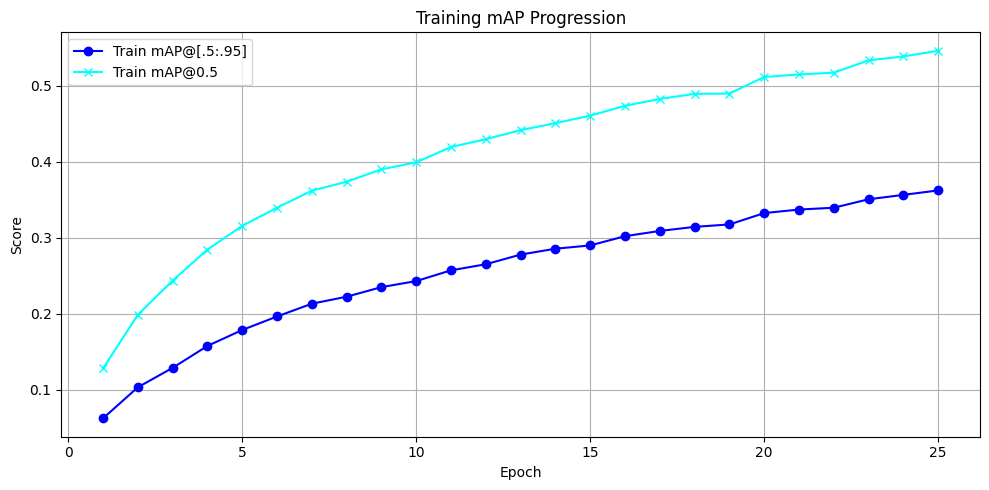

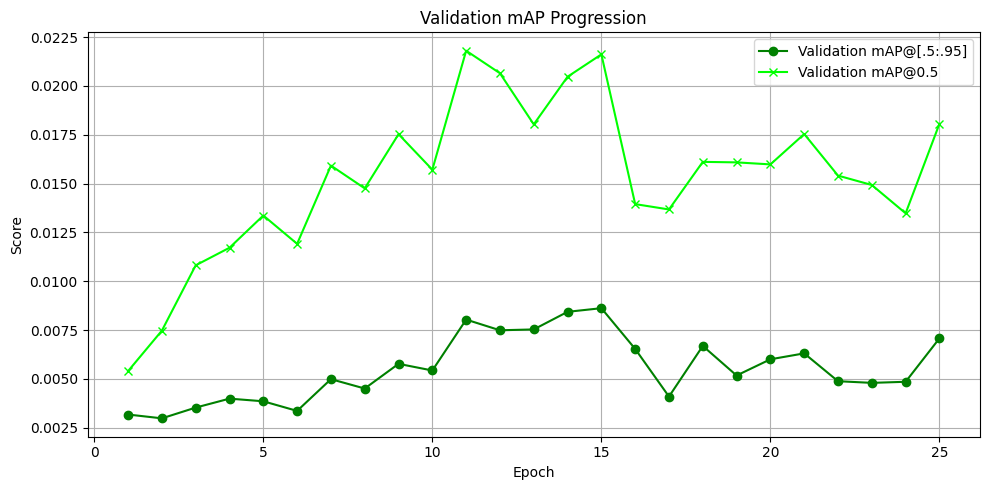

In [13]:
import os
import gc
import torch
import matplotlib.pyplot as plt

save_dir = "./output"
os.makedirs(save_dir, exist_ok=True)

# Lists to track metrics
epochs = []

train_map = []
train_map50 = []
val_map = []
val_map50 = []

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    # === Train ===
    train_one_epoch(model, train_data_loader, DEVICE, optimizer, print_freq=50, epoch=epoch, scaler=scaler)

    # === Evaluate on training set ===
    train_result = evaluate(model, train_data_loader, DEVICE, epoch=None, save_dir=None)
    train_map.append(train_result['map'].item())
    train_map50.append(train_result['map_50'].item())

    # === Evaluate on validation set ===
    val_result = evaluate(model, val_data_loader, DEVICE, epoch=epoch, save_dir='predictions')
    val_map.append(val_result['map'].item())
    val_map50.append(val_result['map_50'].item())
    epochs.append(epoch + 1)

    # Save best model
    if val_result['map'].item() > best_map:
        best_map = val_result['map'].item()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_map': best_map,
            'scaler': scaler.state_dict() if scaler is not None else None
        }, f'{save_dir}/best_model_checkpoint_epoch_{epoch}.pth')

print("That's it!")
writer.close()

# === Plot 1: Training mAP@[.5:.95] vs mAP@0.5 ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_map, marker='o', label='Train mAP@[.5:.95]', color='blue')
plt.plot(epochs, train_map50, marker='x', label='Train mAP@0.5', color='cyan')
plt.title('Training mAP Progression')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{save_dir}/train_map_plot.png')
plt.show()

# === Plot 2: Validation mAP@[.5:.95] vs mAP@0.5 ===
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_map, marker='o', label='Validation mAP@[.5:.95]', color='green')
plt.plot(epochs, val_map50, marker='x', label='Validation mAP@0.5', color='lime')
plt.title('Validation mAP Progression')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{save_dir}/val_map_plot.png')
plt.show()


In [14]:
checkpoint_path = "/kaggle/working/output/best_model_checkpoint_epoch_7.pth"
# Function to load the trained model
def load_model(checkpoint_path, device):
    model = detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False, num_classes=6,box_nms_thresh=0.3)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model
 
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model(checkpoint_path, device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 131MB/s] 


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/output/best_model_checkpoint_epoch_7.pth'

In [ ]:
import torch
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ====== 1. Load and preprocess thae image ======
image_path = "/kaggle/working/warehouse-1/test/1041302-2676_jpg.rf.6d919ad0e2910aa73a4b0328c5c6cd1f.jpg"  # change to your image path
image = Image.open(image_path).convert("RGB")

# Resize and convert to tensor
img_tensor = F.to_tensor(image).unsqueeze(0).to(device)  # Add batch dimension

# ====== 2. Run the model on the image ======
model.eval()
with torch.no_grad():
    prediction = model(img_tensor)[0]  # Get the first output (only one image)

# ====== 3. Visualize the prediction ======
# Convert image back to CPU tensor for display
img_for_display = img_tensor[0].cpu()

# Plotting
fig, ax = plt.subplots(1, figsize=(12, 12))
show_image_with_boxes(img_for_display, prediction, ax, category_colors)
ax.axis("off")
plt.show()
